# Neural Turing Machine

## Setup

In [1]:
# Clone the code repository
!git clone https://github.com/pranavteja-AI/Neural-Turing-Machine

Cloning into 'Neural-Turing-Machine'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [2]:
cd Neural-Turing-Machine

/content/Neural-Turing-Machine


## Train

In [3]:
%%time
# Run training script
!python train.py

  0% 0/10000 [00:00<?, ?it/s]Step 0 == Loss 0.687 == Error 52.0 bits per sequence
  2% 200/10000 [00:10<07:37, 21.44it/s]Step 200 == Loss 0.693 == Error 39.885 bits per sequence
  4% 400/10000 [00:20<07:16, 21.98it/s]Step 400 == Loss 0.692 == Error 34.885 bits per sequence
  6% 600/10000 [00:31<08:05, 19.35it/s]Step 600 == Loss 0.681 == Error 36.255 bits per sequence
  8% 799/10000 [00:41<10:12, 15.02it/s]Step 800 == Loss 0.668 == Error 34.835 bits per sequence
 10% 998/10000 [00:52<07:36, 19.73it/s]Step 1000 == Loss 0.658 == Error 35.06 bits per sequence
 12% 1200/10000 [01:02<08:44, 16.77it/s]Step 1200 == Loss 0.646 == Error 33.305 bits per sequence
 14% 1400/10000 [01:13<08:03, 17.78it/s]Step 1400 == Loss 0.645 == Error 34.73 bits per sequence
 16% 1599/10000 [01:23<07:10, 19.50it/s]Step 1600 == Loss 0.602 == Error 30.445 bits per sequence
 18% 1797/10000 [01:33<07:45, 17.60it/s]Step 1800 == Loss 0.621 == Error 33.415 bits per sequence
 20% 2000/10000 [01:44<06:38, 20.07it/s]Step 20

## Predict

In [4]:
import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T

from ntm import NTM
from task_generator import CopyDataset, AssociativeDataset

### Task Data

In [5]:
# ==== Load the Task Configuration files ====
# Copy Task ===
task_params = json.load(open('configs/copy.json'))
task_params['min_seq_len'] = 100
task_params['max_seq_len'] = 120

# Associative Recall Task ===
# task_params['min_item'] = 6
# task_params['max_item'] = 9

In [6]:
# ==== Create Dataset ====
dataset = CopyDataset(task_params)

### Model

In [7]:
# ==== Create NTM ====
ntm = NTM(input_dim=task_params['seq_width'] + 2,
          output_dim=task_params['seq_width'],
          ctrl_dim=task_params['controller_size'],
          memory_units=task_params['memory_units'],
          memory_unit_size=task_params['memory_unit_size'],
          num_heads=task_params['num_heads'])

In [8]:
# Load trained model weights
ntm.load_state_dict(torch.load('model_copy.pt'))

<All keys matched successfully>

### Predict

In [9]:
# Reset
ntm.reset()

# Sample data
data = dataset[np.random.randint(65536)]
inputs, target = data['input'], data['target']

# Tensor to store outputs
out = torch.zeros(target.size())

# Process the inputs through NTM for memorization
for i in range(inputs.size()[0]):
    # Forward passing all sequences for read
    ntm(inputs[i].unsqueeze(0))

# Get the outputs from memory without real inputs
zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
for i in range(target.size()[0]):
    out[i] = ntm(zero_inputs)

# Calculate binary outputs
binary_output = out.clone()
binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

# Sequence prediction error is calculted in bits per sequence
error = torch.sum(torch.abs(binary_output - target))

print(f'Output Shape: {binary_output.size()}')
print(f'Error: {error} bits per sequence')

Output Shape: torch.Size([101, 8])
Error: 403.0 bits per sequence


### Visualize

In [10]:
# Transforms Compose object
visualize = T.Compose([T.ToPILImage(), T.Resize(128, interpolation=0)])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


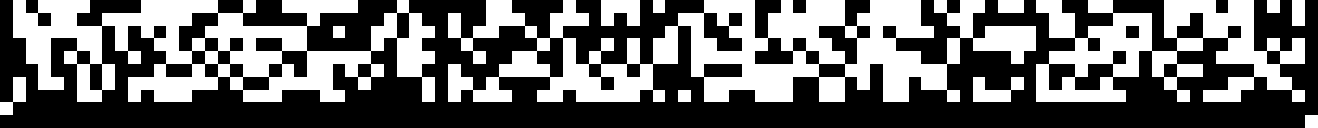

In [11]:
# Visualize Input (with delimiters)
visualize(inputs.permute(1, 0))

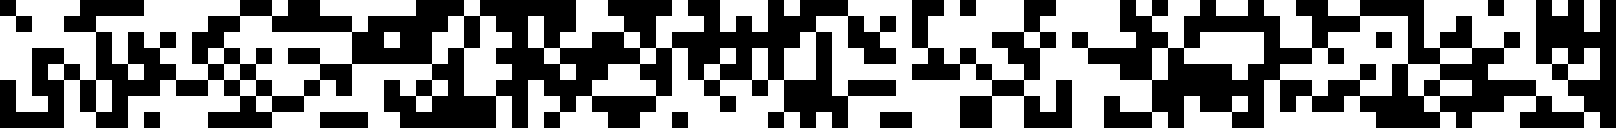

In [12]:
# Visualize Predicted Output
visualize(binary_output.permute(1, 0))